# File for looking at simplistic target and pathway overlap using the Jaccard Similarity #

- Using the syntoxtarg_allpw.csv and syntoxtarg_lowestpw.csv

Steps to take:
1. For all available drug combinations, find the Jaccard similarity for targets
2. For all available drug combinations, find the Jaccard similarity for lowest pathway levels
3. For all available drug combinations, find the Jaccard similarity for all pathway levels

In [11]:
# Import everything needed
from scipy import stats
from toxicity_ranking import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp

In [12]:
drug_syntox_df = pd.read_csv('data_processed/syntox_known.csv')
drug_syntox_df

,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate
1,chloroquine,tamoxifen,TC-32,8.836970,-0.671750,11.944238,-0.517536,Major
2,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate
3,fingolimod,tamoxifen,TC-32,8.007900,-0.764699,5.141360,-0.060902,Major
4,dasatinib,tamoxifen,TC-32,-9.601561,0.314544,-5.351887,0.710809,Moderate
...,...,...,...,...,...,...,...,...
37840,sunitinib,nilutamide,CBRC058,10.012172,7.477252,-6.487555,-8.811142,Moderate
37841,sunitinib,midostaurin,CBRC058,-15.618223,-46.106561,-80.053050,-73.693958,Moderate
37842,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate
37843,ceritinib,ponatinib,RD,11.951861,-2.135860,11.637520,-1.042661,Major


In [13]:
syntoxtarg_allpw_df = pd.read_csv('data_processed/syntoxtarg_allpw.csv')
syntoxtarg_lowestpw_df = pd.read_csv('data_processed/syntoxtarg_lowestpw.csv')

syntoxtarg_allpw_df

,drug_name,target_name,target_DrugBank_ID,UniProtKB_ID,Reactome_ID,Pathway_Name
0,tacrine,Cholinesterase,BE0002180,P06276,R-HSA-112311,Neurotransmitter clearance
1,tacrine,Cholinesterase,BE0002180,P06276,R-HSA-112315,Transmission across Chemical Synapses
2,tacrine,Cholinesterase,BE0002180,P06276,R-HSA-112316,Neuronal System
3,tacrine,Cholinesterase,BE0002180,P06276,R-HSA-1430728,Metabolism
4,tacrine,Cholinesterase,BE0002180,P06276,R-HSA-1483191,Synthesis of PC
...,...,...,...,...,...,...
31598,selumetinib,Dual specificity mitogen-activated protein kin...,BE0004744,P36507,R-HSA-9649948,Signaling downstream of RAS mutants
31599,selumetinib,Dual specificity mitogen-activated protein kin...,BE0004744,P36507,R-HSA-9652169,Signaling by MAP2K mutants
31600,selumetinib,Dual specificity mitogen-activated protein kin...,BE0004744,P36507,R-HSA-9656223,Signaling by RAF1 mutants
31601,selumetinib,Dual specificity mitogen-activated protein kin...,BE0004744,P36507,R-HSA-9675108,Nervous system development


In [14]:
# Function to get the jaccard similarity between two sets of drug targets or pathways
def targ_pw_js(drug1, drug2, target_or_pathway_df, type='target'):
    if type not in ['target', 'pathway']:
        raise ValueError('type must be either target or pathway')
    if type == 'target':
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['target_DrugBank_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['target_DrugBank_ID'])
    else:
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['Reactome_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['Reactome_ID'])
    
    if len(drug1_set) == 0 or len(drug2_set) == 0:
        return None

    return jaccard_similarity(drug1_set, drug2_set)

# Test this function
print(targ_pw_js('ceritinib', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='target')) # Should be None
print(targ_pw_js('mycophenolic acid', 'rucaparib', syntoxtarg_lowestpw_df, type='pathway')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='pathway')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='pathway')) # Should be None


0.0
0.3333333333333333
None
0.0
0.71875
None


In [15]:
# Create a new column in the drug_syntox_df that contains the jaccard similarity between the target sets of the drug pair
drug_syntox_df['target_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'target'), axis=1)
drug_syntox_df['all_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'pathway'), axis=1)
drug_syntox_df['lowest_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_lowestpw_df, 'pathway'), axis=1)

In [16]:
# How many pairs have a target jaccard similarity of None
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'].isnull()]))

# How many pairs have a target jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'] == 0]))

drug_syntox_df

8781
26712
8781
2808
8781
17486


,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category,target_jaccard,all_pw_jaccard,lowest_pw_jaccard
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate,0.0,0.027473,0.000000
1,chloroquine,tamoxifen,TC-32,8.836970,-0.671750,11.944238,-0.517536,Major,0.0,0.134199,0.000000
2,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate,0.0,0.065574,0.015625
3,fingolimod,tamoxifen,TC-32,8.007900,-0.764699,5.141360,-0.060902,Major,0.0,0.136546,0.021053
4,dasatinib,tamoxifen,TC-32,-9.601561,0.314544,-5.351887,0.710809,Moderate,0.0,0.211628,0.065789
...,...,...,...,...,...,...,...,...,...,...,...
37840,sunitinib,nilutamide,CBRC058,10.012172,7.477252,-6.487555,-8.811142,Moderate,0.0,0.034483,0.000000
37841,sunitinib,midostaurin,CBRC058,-15.618223,-46.106561,-80.053050,-73.693958,Moderate,0.5,0.521739,0.621053
37842,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate,0.0,0.086207,0.000000
37843,ceritinib,ponatinib,RD,11.951861,-2.135860,11.637520,-1.042661,Major,0.0,0.012903,0.000000


(array([2.6734e+04, 7.5800e+02, 2.8300e+02, 1.2800e+02, 9.9000e+01,
        4.0000e+00, 2.5400e+02, 0.0000e+00, 2.0000e+00, 2.6100e+02,
        3.6600e+02, 0.0000e+00, 0.0000e+00, 5.7000e+01, 0.0000e+00,
        6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

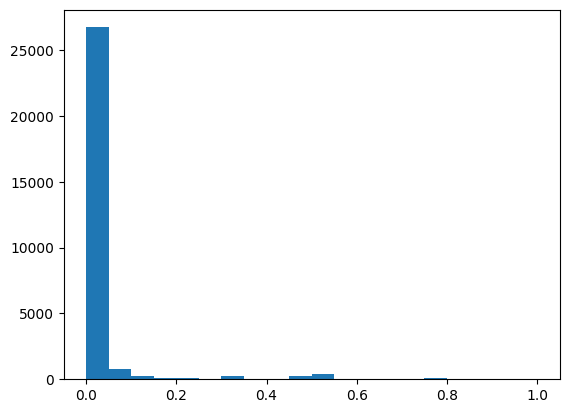

In [17]:
# Look at histogram of target jaccard similarities
plt.hist(drug_syntox_df['target_jaccard'], bins=20)

(array([12162.,  8552.,  4663.,  1302.,   395.,   445.,   117.,    17.,
           93.,   265.,    54.,    63.,    57.,   152.,     0.,   239.,
          259.,    45.,     0.,   184.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

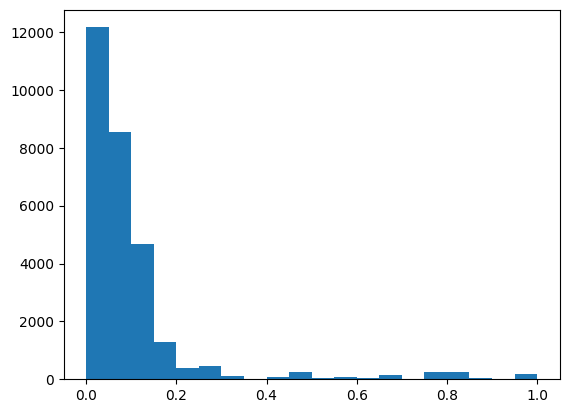

In [18]:
# Look at histogram of pathway jaccard similarities
plt.hist(drug_syntox_df['all_pw_jaccard'], bins=20)

(array([2.4707e+04, 1.5150e+03, 3.1300e+02, 6.5200e+02, 4.2600e+02,
        5.2000e+01, 4.7000e+01, 3.0000e+00, 0.0000e+00, 3.1500e+02,
        1.0900e+02, 1.0000e+00, 7.8000e+01, 1.1900e+02, 2.6000e+02,
        2.3800e+02, 4.5000e+01, 0.0000e+00, 0.0000e+00, 1.8400e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

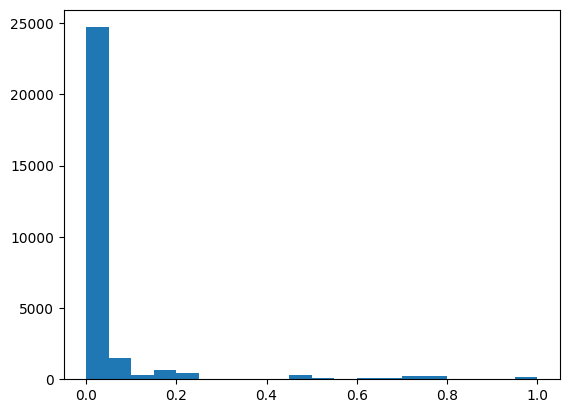

In [19]:
# Look at histogram of lowest pathway jaccard similarities
plt.hist(drug_syntox_df['lowest_pw_jaccard'], bins=20)

Then break down the dataset in different ways and see if there are any correlations. None of these Jaccard similarities are a normal distribution, so probably look at using a Kruskal Wallis test:
1. Break down by Major, Moderate, Minor toxicity, is there any difference in Jaccard similarity by these groups?

In [35]:
# Run Kruskal Wallis test on jaccard similarities with targeting Major, Moderate, and Minor toxicity

# Target jaccard
major_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['target_jaccard'].dropna()
moderate_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['target_jaccard'].dropna()
minor_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['target_jaccard'].dropna()
print(f'Major target jaccard: {len(major_target)}')
print(f'Moderate target jaccard: {len(moderate_target)}')
print(f'Minor target jaccard: {len(minor_target)}')

h_statistic_target_tox, p_value_target_tox = stats.kruskal(major_target, moderate_target, minor_target)
print(f'Kruskal-Wallis H statistic for target jaccard: {h_statistic_target_tox}')
print(f'P-value for target jaccard: {p_value_target_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with target jaccard similarity of None
drug_syntox_df_tox_target = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_target = drug_syntox_df_tox_target[~drug_syntox_df_tox_target['target_jaccard'].isnull()]
dunn_target_tox = sp.posthoc_dunn(drug_syntox_df_tox_target, val_col='target_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for target jaccard:' + str(dunn_target_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_target.values.tolist()
jaccard_moderate_samples = moderate_target.values.tolist()
jaccard_minor_samples = minor_target.values.tolist()
jt_incr_target = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for Target overlap: ", jt_incr_target )
jt_decr_target = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for Target overlap: ", jt_decr_target)

###################################
# Pathway (lowest levels) jaccard
major_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['lowest_pw_jaccard'].dropna()
moderate_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['lowest_pw_jaccard'].dropna()
minor_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['lowest_pw_jaccard'].dropna()
print(f'Major lowest pathway jaccard: {len(major_lowestpw)}')
print(f'Moderate lowest pathway jaccard: {len(moderate_lowestpw)}')
print(f'Minor lowest pathway jaccard: {len(minor_lowestpw)}')

h_statistic_lowestpw_tox, p_value_lowestpw_tox = stats.kruskal(major_lowestpw, moderate_lowestpw, minor_lowestpw)
print(f'Kruskal-Wallis H statistic for lowest pathway jaccard: {h_statistic_lowestpw_tox}')
print(f'P-value for lowest pathway jaccard: {p_value_lowestpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with lowest pathway levels jaccard similarity of None
drug_syntox_df_tox_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_lowestpw = drug_syntox_df_tox_lowestpw[~drug_syntox_df_tox_lowestpw['lowest_pw_jaccard'].isnull()]
dunn_lowestpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_lowestpw, val_col='lowest_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for lowest pathway jaccard:' + str(dunn_lowestpw_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_lowestpw.values.tolist()
jaccard_moderate_samples = moderate_lowestpw.values.tolist()
jaccard_minor_samples = minor_lowestpw.values.tolist()
jt_incr_lowestpw = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for Lowest Pathway overlap: ", jt_incr_lowestpw )
jt_decr_lowestpw = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for Lowest Pathway overlap: ", jt_decr_lowestpw)

###################################
# Pathway (all levels) jaccard
major_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['all_pw_jaccard'].dropna()
moderate_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['all_pw_jaccard'].dropna()
minor_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['all_pw_jaccard'].dropna()
print(f'Major all pathway jaccard: {len(major_allpw)}')
print(f'Moderate all pathway jaccard: {len(moderate_allpw)}')
print(f'Minor all pathway jaccard: {len(minor_allpw)}')

h_statistic_allpw_tox, p_value_allpw_tox = stats.kruskal(major_allpw, moderate_allpw, minor_allpw)
print(f'Kruskal-Wallis H statistic for all pathway jaccard: {h_statistic_allpw_tox}')
print(f'P-value for all pathway jaccard: {p_value_allpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with all pathway levels jaccard similarity of None
drug_syntox_df_tox_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_allpw = drug_syntox_df_tox_allpw[~drug_syntox_df_tox_allpw['all_pw_jaccard'].isnull()]
dunn_allpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_allpw, val_col='all_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for all pathway jaccard:' + str(dunn_allpw_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_allpw.values.tolist()
jaccard_moderate_samples = moderate_allpw.values.tolist()
jaccard_minor_samples = minor_allpw.values.tolist()
jt_incr_allpw = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for All Pathway overlap: ", jt_incr_allpw )
jt_decr_allpw = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for All Pathway overlap: ", jt_decr_allpw)


with open('results/jaccard_similarity_analysis/targpw_tox_jaccard.tsv', 'w') as f:
    f.write('Level\tTest\tTest statistic\tP-value\n')
    f.write(f'Target\tKruskal-Wallis\t{h_statistic_target_tox}\t{p_value_target_tox}\n')
    f.write(f'Target\tDunn post-hoc\tMajor/Minor\t{dunn_target_tox.iloc[0, 1]}\n')
    f.write(f'Target\tDunn post-hoc\tMajor/Moderate\t{dunn_target_tox.iloc[0, 2]}\n')
    f.write(f'Target\tDunn post-hoc\tModerate/Minor\t{dunn_target_tox.iloc[1, 2]}\n')
    f.write(f'Target\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_target[0]}\t{jt_incr_target[1]}\n')
    f.write(f'Target\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_target[0]}\t{jt_decr_target[1]}\n')
    f.write(f'Lowest pathway\tKruskal-Wallis\t{h_statistic_lowestpw_tox}\t{p_value_lowestpw_tox}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tMajor/Minor\t{dunn_lowestpw_tox.iloc[0, 1]}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tMajor/Moderate\t{dunn_lowestpw_tox.iloc[0, 2]}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tModerate/Minor\t{dunn_lowestpw_tox.iloc[1, 2]}\n')
    f.write(f'Lowest pathway\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_lowestpw[0]}\t{jt_incr_lowestpw[1]}\n')
    f.write(f'Lowest pathway\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_lowestpw[0]}\t{jt_decr_lowestpw[1]}\n')
    f.write(f'All pathway\tKruskal-Wallis\t{h_statistic_allpw_tox}\t{p_value_allpw_tox}\n')
    f.write(f'All pathway\tDunn post-hoc\tMajor/Minor\t{dunn_allpw_tox.iloc[0, 1]}\n')
    f.write(f'All pathway\tDunn post-hoc\tMajor/Moderate\t{dunn_allpw_tox.iloc[0, 2]}\n')
    f.write(f'All pathway\tDunn post-hoc\tModerate/Minor\t{dunn_allpw_tox.iloc[1, 2]}\n')
    f.write(f'All pathway\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_allpw[0]}\t{jt_incr_allpw[1]}\n')
    f.write(f'All pathway\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_allpw[0]}\t{jt_decr_allpw[1]}\n')



Major target jaccard: 5776
Moderate target jaccard: 22457
Minor target jaccard: 831
Kruskal-Wallis H statistic for target jaccard: 156.47337491620945
P-value for target jaccard: 1.05253938225393e-34
Dunn post-hoc test for target jaccard:                 Major         Minor      Moderate
Major     1.000000e+00  1.352075e-25  9.079921e-22
Minor     1.352075e-25  1.000000e+00  5.719235e-12
Moderate  9.079921e-22  5.719235e-12  1.000000e+00
Increasing toxicity for Target overlap:  (5.678687992488283, 6.7865901787200755e-09)
Decreasing toxicity for Target overlap:  (-5.678687992488283, 0.9999999932134098)
Major lowest pathway jaccard: 5776
Moderate lowest pathway jaccard: 22457
Minor lowest pathway jaccard: 831
Kruskal-Wallis H statistic for lowest pathway jaccard: 1584.1166351503912
P-value for lowest pathway jaccard: 0.0
Dunn post-hoc test for lowest pathway jaccard:             Major         Minor      Moderate
Major     1.000000  2.140724e-01  0.000000e+00
Minor     0.214072  1.000000e+

2. Could try to do a continuous correlation between synergy scores and Jaccard similarity distributions between these groups
    1. Do for Bliss, HSA, ZIP, Loewe synergy scores

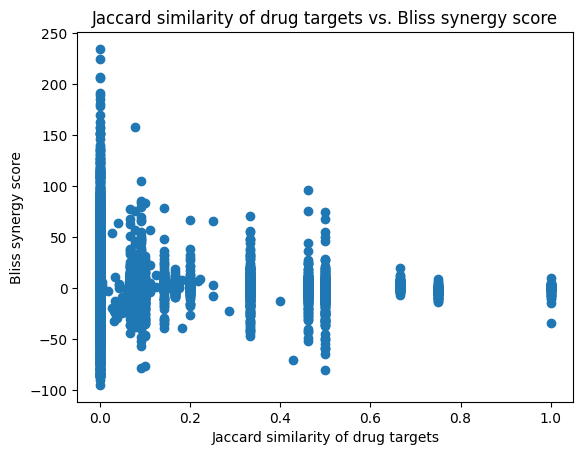

Pearson correlation coefficient between target jaccard similarity and bliss synergy score: -0.01762477911418044
Spearman correlation coefficient between target jaccard similarity and bliss synergy score: -0.004092025662425794


In [21]:
# Let's plot jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug targets vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and bliss synergy score
target_jaccard_bliss_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between target jaccard similarity and bliss synergy score: {target_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and bliss synergy score
target_jaccard_bliss_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and bliss synergy score: {target_jaccard_bliss_spearman_corr}')


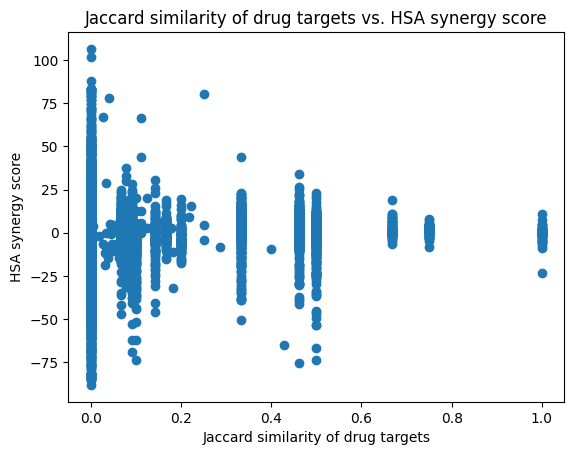

Pearson correlation coefficient between target jaccard similarity and HSA synergy score: -0.007835543609508614
Spearman correlation coefficient between target jaccard similarity and HSA synergy score: -0.026949046716731657


In [22]:
# Let's plot jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug targets vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and HSA synergy score
target_jaccard_hsa_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between target jaccard similarity and HSA synergy score: {target_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and HSA synergy score
target_jaccard_hsa_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and HSA synergy score: {target_jaccard_hsa_spearman_corr}')

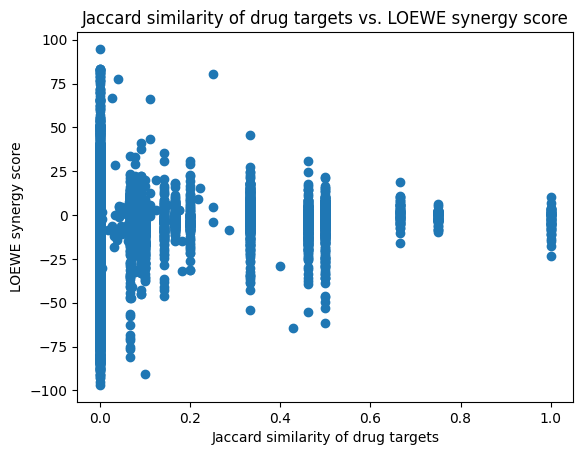

Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score: 0.06347057723748037
Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score: 0.07198351275880906


In [23]:
# Let's plot jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug targets vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score
target_jaccard_loewe_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score: {target_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score
target_jaccard_loewe_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score: {target_jaccard_loewe_spearman_corr}')


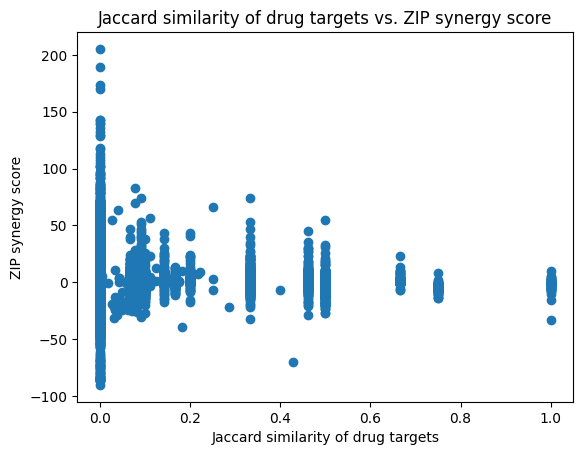

Pearson correlation coefficient between target jaccard similarity and ZIP synergy score: -0.01960691992870583
Spearman correlation coefficient between target jaccard similarity and ZIP synergy score: -0.006493363240289049


In [24]:
# Let's plot jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug targets vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and ZIP synergy score
target_jaccard_zip_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between target jaccard similarity and ZIP synergy score: {target_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and ZIP synergy score
target_jaccard_zip_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and ZIP synergy score: {target_jaccard_zip_spearman_corr}')

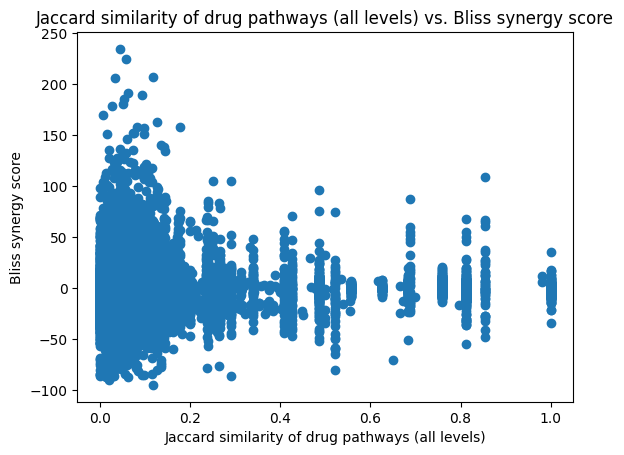

Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: -0.001457456854270684
Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: 0.03474391506554247


In [25]:
# Let's plot all pathway levels jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score
allpw_jaccard_bliss_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: {allpw_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score
allpw_jaccard_bliss_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: {allpw_jaccard_bliss_spearman_corr}')

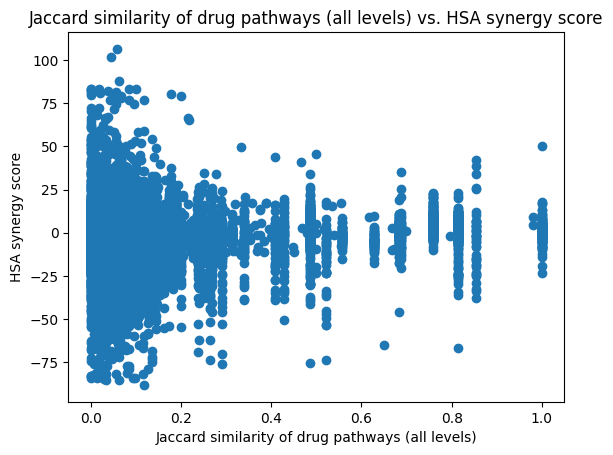

Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: -0.005695518008089778
Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: -0.02796440586969088


In [26]:
# Let's plot all pathway levels jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score
allpw_jaccard_hsa_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: {allpw_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score
allpw_jaccard_hsa_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: {allpw_jaccard_hsa_spearman_corr}')


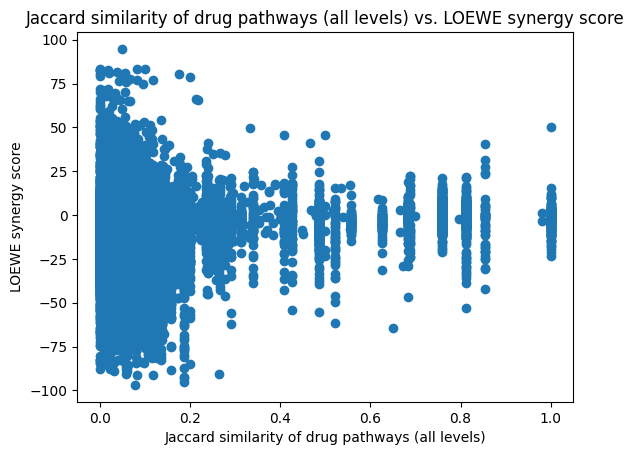

Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: 0.06859291068298352
Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: 0.029482611419584498


In [27]:
# Let's plot all pathway levels jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score
allpw_jaccard_loewe_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: {allpw_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score
allpw_jaccard_loewe_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: {allpw_jaccard_loewe_spearman_corr}')

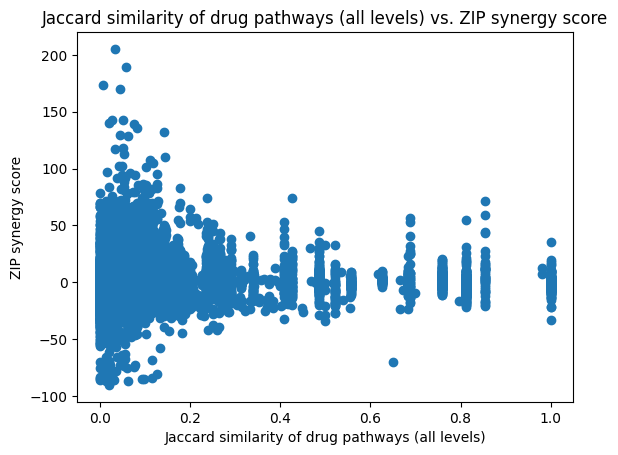

Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: -0.0002975476998301229
Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: 0.03744505974988322


In [28]:
# Let's plot all pathway levels jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score
allpw_jaccard_zip_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: {allpw_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score
allpw_jaccard_zip_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: {allpw_jaccard_zip_spearman_corr}')


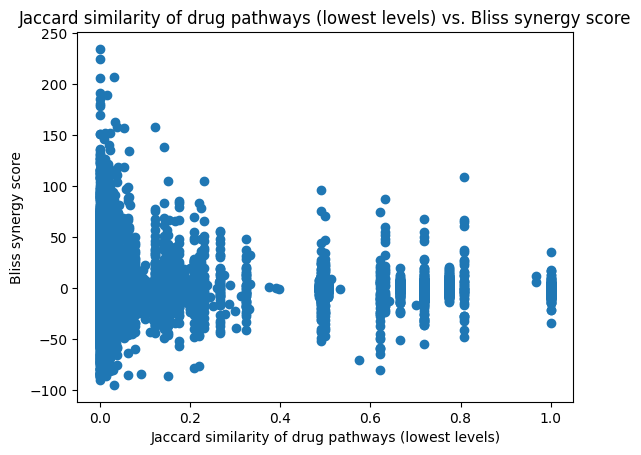

Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: -0.0063912914991291064
Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: 0.028559997041366556


In [29]:
# Let's plot lowest pathway levels jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score
lowestpw_jaccard_bliss_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: {lowestpw_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score
lowestpw_jaccard_bliss_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: {lowestpw_jaccard_bliss_spearman_corr}')

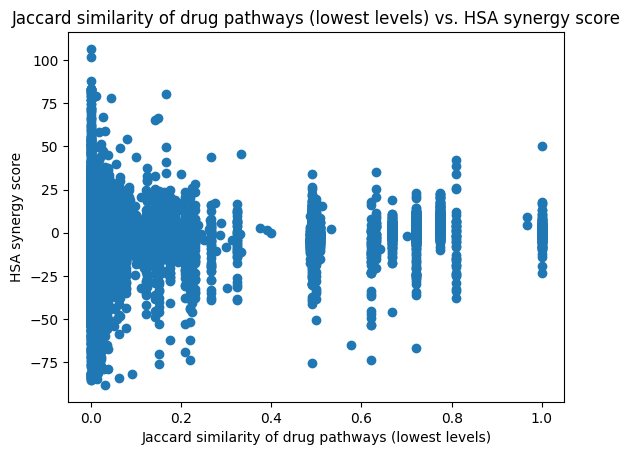

Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: -0.0031003729267797507
Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: -0.042874603757707755


In [30]:
# Let's plot lowest pathway levels jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score
lowestpw_jaccard_hsa_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: {lowestpw_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score
lowestpw_jaccard_hsa_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: {lowestpw_jaccard_hsa_spearman_corr}')

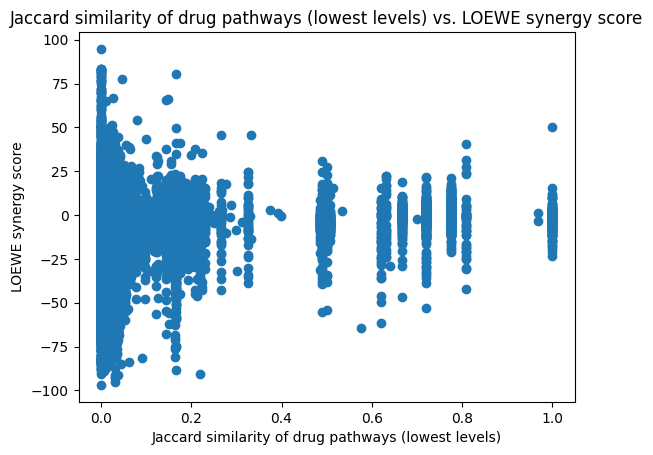

Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: 0.07598914822838
Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: 0.057597524050639094


In [31]:
# Let's plot lowest pathway levels jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score
lowestpw_jaccard_loewe_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: {lowestpw_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score
lowestpw_jaccard_loewe_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: {lowestpw_jaccard_loewe_spearman_corr}')

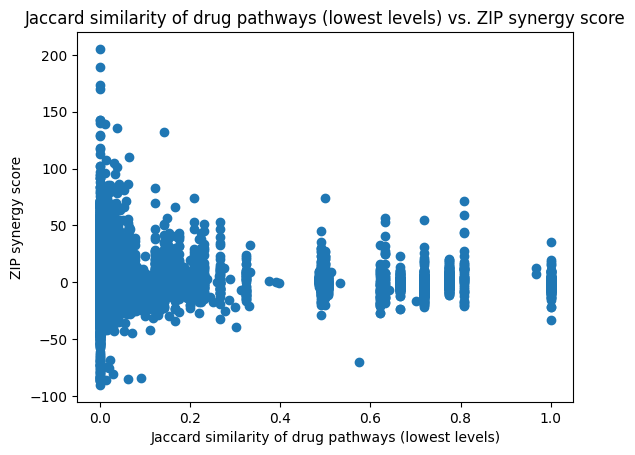

Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: -0.006038601174204547
Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: 0.026652386512340143


In [32]:
# Let's plot lowest pathway levels jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score
lowestpw_jaccard_zip_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: {lowestpw_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score
lowestpw_jaccard_zip_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: {lowestpw_jaccard_zip_spearman_corr}')

In [33]:
# Write all the correlations and spearman correlations to a file
with open('results/jaccard_similarity_analysis/targpw_synergy_correlations_jaccard.tsv', 'w') as f:
    f.write('Synergy score\tLevel\tPearson correlation coefficient\tSpearman correlation\n')
    f.write(f'Bliss\tTarget\t{target_jaccard_bliss_corr}\t{target_jaccard_bliss_spearman_corr}\n')
    f.write(f'Bliss\tAll pathway\t{allpw_jaccard_bliss_corr}\t{allpw_jaccard_bliss_spearman_corr}\n')
    f.write(f'Bliss\tLowest pathway\t{lowestpw_jaccard_bliss_corr}\t{lowestpw_jaccard_bliss_spearman_corr}\n')
    f.write(f'HSA\tTarget\t{target_jaccard_hsa_corr}\t{target_jaccard_hsa_spearman_corr}\n')
    f.write(f'HSA\tAll pathway\t{allpw_jaccard_hsa_corr}\t{allpw_jaccard_hsa_spearman_corr}\n')
    f.write(f'HSA\tLowest pathway\t{lowestpw_jaccard_hsa_corr}\t{lowestpw_jaccard_hsa_spearman_corr}\n')
    f.write(f'Loewe\tTarget\t{target_jaccard_loewe_corr}\t{target_jaccard_loewe_spearman_corr}\n')
    f.write(f'Loewe\tAll pathway\t{allpw_jaccard_loewe_corr}\t{allpw_jaccard_loewe_spearman_corr}\n')
    f.write(f'Loewe\tLowest pathway\t{lowestpw_jaccard_loewe_corr}\t{lowestpw_jaccard_loewe_spearman_corr}\n')
    f.write(f'ZIP\tTarget\t{target_jaccard_zip_corr}\t{target_jaccard_zip_spearman_corr}\n')
    f.write(f'ZIP\tAll pathway\t{allpw_jaccard_zip_corr}\t{allpw_jaccard_zip_spearman_corr}\n')
    f.write(f'ZIP\tLowest pathway\t{lowestpw_jaccard_zip_corr}\t{lowestpw_jaccard_zip_spearman_corr}\n')
